In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid.inset_locator import mark_inset
frame_id = 3
block_region = pd.read_csv("block_region_"+str(frame_id)+".csv", sep=",")
st_nodes = pd.read_csv("st_node_"+str(frame_id)+".csv", sep=",")

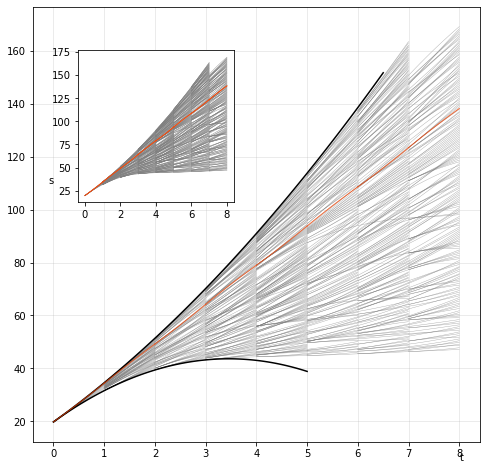

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8, 8))
axin = ax.inset_axes([0.1, 0.55, 0.35, 0.35])

# s-t nodes
for idx, row in st_nodes.iterrows():
    [s0, v0, a, t0, tf] = row[0:5]
    t = np.linspace(0, tf, 10)
    s = s0 + v0 * t + 0.5 * a * t ** 2
    t += t0
    [color, lw, zorder] = ["gray", 0.4, 1]
    if row[-2] == 1:
        [color, lw, zorder] = ["orangered", 1.0, 120]
    ax.plot(t, s, lw=lw, color=color, zorder=zorder, alpha=0.7)
    axin.plot(t, s, lw=lw, color=color, zorder=zorder)

# block region
for idx, row in block_region.iterrows():
    x = row[0:5]
    y = row[5:10]
    ax.plot(x, y, color="b", lw=1)

# boundary
bound_color = "k"
t = np.linspace(0, 6.5, 100)
s_upper = st_nodes['s0'][0] + st_nodes['v0'][0] * t + 0.5 * 2 * t ** 2
ax.plot(t, s_upper, lw=1.5, color=bound_color)
# s_max = st_nodes['v0'][0] + st_nodes['v0'][0]**2 / 8
# ax.plot([2.5, 8], [s_max, s_max], lw=1.5, color=bound_color)
t = np.linspace(0, 5, 100)
s_lower = st_nodes['s0'][0] + st_nodes['v0'][0] * t - 0.5 * 4 * t ** 2
ax.plot(t, s_lower, lw=1.5, color=bound_color)

zoom_color = "darkblue"

# axin.set_xlim(2.5, 3.5)
# axin.set_ylim(36, 46)
# patch, pp1, pp2 = mark_inset(
#     ax, axin, loc1=3, loc2=1, fc="none", ec=zoom_color, lw=1, zorder=100
# )
# pp1.loc2 = 2
# pp2.loc1 = 4
# pp2.loc2 = 1

# ax.set_axis_off()
# axin.set_axis_off()

# fu.set_axis_color(axin, zoom_color)

# tex_fonts = {
#     # Use LaTeX to write all text
# #     "text.usetex": True,
#     "font.family": "Times New Roman",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 10,
#     "font.size": 10,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 8,
#     "xtick.labelsize": 8,
#     "ytick.labelsize": 8,
# }
# plt.rcParams.update(tex_fonts)
# ax.set_xticks(np.linspace(0, 8, 9))
# ax.set_yticks(np.linspace(0, 120, 60))
ax.grid(alpha=0.3)
ax.text(8, 5, "t")
ax.text(-0.1, 110, "s")

my_fc = "fuchsia"


# def draw_polygon(ax, polygon):
#     # ax.add_patch(Polygon(polygon, color="w", fill=True, alpha=1, zorder=100, lw=0.1))
#     ax.add_patch(
#         Polygon(
#             polygon,
#             closed=True,
#             color=my_fc,
#             fill=False,
#             hatch="\\\\\\\\",
#             lw=0.6,
#             zorder=101,
#         )
#     )
#     ax.add_patch(
#         Polygon(polygon, closed=True, color=my_fc, fill=False, lw=0.8, zorder=102)
#     )


# ax.text(3.5, 8.1, "$a_{min}$", color="b")0
# ax.text(5, 110, "$a_{max}$", color="b")
# ax.text(6.2, 14.2, "$v=0$", color="b")
# ax.add_patch(
#     Polygon(
#         [[5.2, 27], [7.9, 27], [7.9, 36], [5.2, 36]],
#         closed=True,
#         color="w",
#         fill=True,
#         lw=0.8,
#         zorder=2,
#     )
# )
# ax.text(5.2, 30, "convex region", color=my_fc, stretch='extra-condensed')

# ax.plot([4, 5, 5, 4, 4], [22.3, 22.3, 52, 43, 22.5], color="orange", linewidth=1)
# draw_polygon(ax, [[4, 22.3], [5, 22.3], [5, 52], [4, 43], [4, 22.5]])

# ax.arrow(2.5, 8.5, 1, 1)
# ax.annotate(
#     "$a_{max}$", xy=(3, 19), xytext=(1.5, 8.5), arrowprops=dict(width=3, headwidth=5)
# )

# fig.savefig(
#     "../figure/st_node.pdf", format="pdf", bbox_inches="tight", pad_inches=0, dpi=300
# )

plt.show()